# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [270]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
import urllib
import tqdm
import time
import sklearn
import matplotlib.pyplot as plt

In [2]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        word_id = self.word2id[word]
        return self.embeddings[word_id]
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        word1_embedding = self.encode(word1)
        word2_embedding = self.encode(word2)
        cosine_dist = 1 - np.dot(word1_embedding,word2_embedding)/(np.linalg.norm(word1_embedding)*np.linalg.norm(word2_embedding))
        return cosine_dist
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort
        distances = np.array([self.score(word, other_word) for other_word in self.words])
        distances_int = np.argsort(distances)
        neighbors = []
        for rank in range(k+1):
            neighbor_id = distances_int[rank]
            neighbor_wrd = self.id2word[neighbor_id]
            if (not neighbor_wrd==word) and (len(neighbors)!=k):
                # the word itself isn't considered a neighbor
                # a situation might occur in which k neighbors embeddings are colinear to the word embedding
                # thus, the word itself might not appear at first in the top k neighbors
                neighbors.append(neighbor_wrd)
        return neighbors

In [4]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.7355024533834524
cat dog 0.2921358701457436
cat pet 0.32466866400236194
Paris France 0.31070410741934595
Paris Germany 0.5948757713262451
Paris baguette 0.7060004172219778
Paris donut 1.006588507552348
['cats', 'kitty', 'kitten', 'feline', 'dog']
['dogs', 'puppy', 'pup', 'canine', 'pet']
['dog', 'cats', 'puppies', 'Dogs', 'pets']
['France', 'Parisian', 'Marseille', 'Brussels', 'Strasbourg']
['Austria', 'Europe', 'Berlin', 'Hamburg', 'Bavaria']


In [135]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        sentences_nb = len(sentences)
        idf = {word:0 for word in self.word2vec.words}
        for stc in sentences:
            stc_wds = stc.split(' ')
            stc_wds.remove('')
            for word in np.unique(np.array(stc_wds)):
                try:
                    idf[word]+=1
                except:
                    pass # because this means that the word isn't in the known words
        for word in self.word2vec.words:
            try:
                idf[word] = np.log(sentences_nb / idf[word]) if idf[word] > 0 else 0
            except:
                pass # because this means that the word isn't in the known words
            
        return idf
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        sentence = sentence.split(' ')
        try:
            sentence.remove('')
        except:
            pass
        embed_sentence = []
        for word in sentence: # Here I could save the known encodings in a dictionnary
            try:
                embed_sentence.append(self.word2vec.encode(word))
            except:
                pass # because this means that the word isn't in the known words
        embed_sentence = np.array(embed_sentence)
        
        if idf is None:
            # mean of word vectors
            return np.mean(embed_sentence, axis=0)
        else:
            # idf-weighted mean of word vectors
            sentence_idf = []
            for word in sentence:
                try:
                    sentence_idf.append(idf[word])
                except:
                    pass # because this means that the word isn't in the known words
            sentence_idf = np.array(sentence_idf).reshape(-1,1)
            result = np.sum(np.multiply(embed_sentence,sentence_idf),axis=0)/np.sum(sentence_idf) \
                            if np.sum(sentence_idf)!=0 else np.zeros(embed_sentence.shape[1])
            return result

    def score(self, sentence1, sentence2, idf=None, encoded=False):
        # cosine similarity: use np.dot & np.linalg.norm 
        if not encoded:
            sentence1_embedding = self.encode(sentence1, idf)
            sentence2_embedding = self.encode(sentence2, idf)
        else:
            sentence1_embedding, sentence2_embedding = sentence1, sentence2
        cosine_dist = 1 - np.dot(sentence1_embedding,sentence2_embedding)/\
                            (np.linalg.norm(sentence1_embedding)*np.linalg.norm(sentence2_embedding))
        return cosine_dist
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        query = self.encode(sentence, idf)
        keys = np.vstack([self.encode(stc, idf) for stc in sentences])
        similarities = [self.score(query, other_stc, idf, encoded=True) for other_stc in tqdm.tqdm(keys)]
        similarities_int = np.argsort(similarities)
        neighbors = []
        for rank in range(k+1):
            neighbor_id = similarities_int[rank]
            neighbor_stc = sentences[neighbor_id]
            if (not neighbor_stc==sentence) and (len(neighbors)!=k):
                # the sentence itself isn't considered a neighbor
                # a situation might occur in which k neighbors embeddings are colinear to the sentence embedding
                # thus, the sentence itself might not appear at first in the top k neighbors
                neighbors.append(neighbor_stc)
        return neighbors

In [136]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]

# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7] # original : 7
sentence2 = sentences[13] # original : 13
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[300] # original : 10
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence_nghbr in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence_nghbr)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence_nghbr in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence_nghbr)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.29347793517485266


100%|██████████| 150736/150736 [00:05<00:00, 26402.92it/s]


3 little kids are playing football . 
1) 3 kids are playing with bubbles outside . 
2) 4 men are playing dominoes together . 
3) 2 kids holding hands and smiling . 
4) 2 hockey teams are playing hockey . 
5) these four people are standing outdoors , with 3 dogs . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.35992000606536156


100%|██████████| 150736/150736 [00:05<00:00, 27904.37it/s]

3 little kids are playing football . 
1) 3 kids are playing with bubbles outside . 
2) five children , 3 boys and 2 girls playing soccer in a grass field . 
3) 2 kids playing on a seesaw 
4) a woman walking with 4 kids . 
5) 5 children , 2 boys and 3 girls , share food while sitting outside of a building . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [17]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) 
        #     (of embeddings for these words)
        X = []
        Y = []
        fr_vocab = set(self.fr_word2vec.words)
        en_vocab = set(self.en_word2vec.words)
        common_vocab = fr_vocab - (fr_vocab - en_vocab)
        
        for wrd in common_vocab:
            X.append(list(self.fr_word2vec.encode(wrd)))
            Y.append(list(self.en_word2vec.encode(wrd)))
        
        #for fr_word in self.fr_word2vec.words:
        #    for en_word in self.en_word2vec.words:
        #        
        #        if fr_word==en_word:
        #            X.append(self.fr_word2vec.encode(fr_word))
        #            Y.append(self.en_word2vec.encode(en_word))
            
        X, Y = np.array(X).transpose(), np.array(Y).transpose()
        assert X.shape[0] == 300 and Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        u, s, vh = np.linalg.svd(np.matmul(Y, X.transpose()))
        W = np.matmul(u, vh)
        assert W.shape == (300, 300)
        return np.matmul(self.fr_word2vec.embeddings, W.transpose())
    
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        fr_wrd_id = self.fr_word2vec.word2id[fr_word]
        fr2en_wrd_emb = self.aligned_fr_embeddings[fr_wrd_id]
        scores = 1 - np.divide(np.dot(fr2en_wrd_emb,self.en_word2vec.embeddings.transpose()),
                               np.linalg.norm(fr2en_wrd_emb)*np.linalg.norm(self.en_word2vec.embeddings,axis=1))
        scores_int = np.argsort(scores)
        neighbors = []
        for rank in range(k):
            neighbor_id = scores_int[rank]
            neighbor_wrd = self.en_word2vec.id2word[neighbor_id]
            neighbors.append(neighbor_wrd)
            
        return neighbors

In [18]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['finance', 'mission', 'attention', 'chat', 'chien', 'voiture', 'zut']
k = 10
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "finance"
en: "finance"
en: "banking"
en: "financial"
en: "economics"
en: "education"
en: "fund"
en: "capitalism"
en: "sector"
en: "financing"
en: "taxation"
----------
fr: "mission"
en: "mission"
en: "missions"
en: "Mission"
en: "Missions"
en: "vocation"
en: "assignment"
en: "rescue"
en: "tasked"
en: "feasibility"
en: "responsibilities"
----------
fr: "attention"
en: "attention"
en: "regard"
en: "consideration"
en: "careful"
en: "concern"
en: "exposition"
en: "mentioning"
en: "emphasis"
en: "beware"
en: "immediate"
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
en: "pet"
en: "dog"
en: "feline"
en: "kittens"
en: "cats"
en: "doggie"
en: "parrot"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
en: "pup"
en: "doggie"
en: "puppy"
en: "canine"
en: "bulldog"
en: "kitten"
en: "dogs"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
en: "motorbike"
en: "motorcycle"
en: "scoot

If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [145]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

# Load training sentences
train_sentences = []
train_labels = []
with open(train_filepath, 'r') as f:
    for line in f:
        data = line.strip('\n')
        train_labels.append(data[0])
        train_sentences.append(data[2:])
        
# Load dev sentences
dev_sentences = []
dev_labels = []
with open(dev_filepath, 'r') as f:
    for line in f:
        data = line.strip('\n')
        dev_labels.append(data[0])
        dev_sentences.append(data[2:])
        
# Load test sentences
test_sentences = []
test_labels = []
with open(test_filepath, 'r') as f:
    for line in f:
        data = line.strip('\n')
        test_sentences.append(data)

In [156]:
# 2 - Encode sentences with the BoV model above
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)
  
train_labels, dev_labels = np.array(train_labels), np.array(dev_labels)
train_sentences_embedding, dev_sentences_embedding, test_sentences_embedding = {}, {}, {}
idf_techniques = {'idf':sentence2vec.build_idf(sentences), 'no_idf':None}
for idf_name in idf_techniques.keys():

    ### Training
    train_embedding = []
    for stc in train_sentences:
        train_embedding.append(sentence2vec.encode(stc, idf_techniques[idf_name]))  # BagOfWords-idf

    train_sentences_embedding[idf_name] = np.array(train_embedding)

    ### Dev
    dev_embedding = []
    for stc in dev_sentences:
        dev_embedding.append(sentence2vec.encode(stc, idf_techniques[idf_name]))  # BagOfWords-idf

    dev_sentences_embedding[idf_name] = np.array(dev_embedding)

    ### Test
    test_embedding = []
    for stc in test_sentences:
        test_embedding.append(sentence2vec.encode(stc, idf_techniques[idf_name]))  # BagOfWords-idf

    test_sentences_embedding[idf_name] = np.array(test_embedding)


### Let's have a first glance at the labels distributions in each dataset

#print('-'*50, 'Training Set')
#for occ in np.unique(train_labels, return_counts=True)[1]:
#    print(occ/len(train_labels))
    
#print('-'*50, 'Dev Set')
#for occ in np.unique(dev_labels, return_counts=True)[1]:
#    print(occ/len(dev_labels))

# The distributions are very close to each other

Loaded 50000 pretrained word vectors


In [170]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

log_reg = {}
for idf_name in idf_techniques.keys():
    print('-'*100, idf_name)
    log_reg[idf_name] = RidgeClassifier(alpha=0.6, fit_intercept=True, max_iter=None, tol=0.001)
    #transformer = PCA(0.95, whiten=True)
    #pca_train_data = transformer.fit_transform(train_sentences_embedding[idf_name])
    log_reg[idf_name].fit(train_sentences_embedding[idf_name], train_labels)
    print('-'*70, 'Training, Cross Validation')
    Accuracy = cross_val_score(log_reg[idf_name], train_sentences_embedding[idf_name], train_labels,
                               cv=5,scoring='accuracy')
    print(Accuracy)
    print('-> Mean training accuracy score : ', round(np.mean(Accuracy), 4))

    print('-'*70, 'Validation')
    #pca_dev_data = transformer.transform(dev_sentences_embedding[idf_name])
    dev_pred_labels = log_reg[idf_name].predict(dev_sentences_embedding[idf_name])
    accuracy = accuracy_score(dev_labels, dev_pred_labels)
    print('Validation accuracy on the dev set : ',round(accuracy,4))
    print('\n\n')

### Conclusion :
# This approach yields better results without the IDF technique. 
# The results are pretty good with a validation accuracy of ~0.40 : can we perform better with other approaches ?
# Interestingly, when we apply a PCA, the results with the idf technique are better than without 
# (but worse than when not using a PCA)

# To go further : GRID SEARCH, ERROR ANALYSIS

---------------------------------------------------------------------------------------------------- idf
---------------------------------------------------------------------- Training, Cross Validation
[0.38807715 0.3886616  0.37039204 0.38781488 0.38921454]
-> Mean training accuracy score :  0.3848
---------------------------------------------------------------------- Validation
Validation accuracy on the dev set :  0.3824



---------------------------------------------------------------------------------------------------- no_idf
---------------------------------------------------------------------- Training, Cross Validation
[0.41729982 0.40736411 0.41310708 0.40480375 0.40152403]
-> Mean training accuracy score :  0.4088
---------------------------------------------------------------------- Validation
Validation accuracy on the dev set :  0.4005





In [180]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

test_pred_labels = log_reg['no_idf'].predict(test_sentences_embedding['no_idf'])
with open(r'logreg_bov_y_test_sst.txt', 'w') as f:
    f.write("\n".join(" ".join(map(str, pred)) for pred in test_pred_labels))

In [179]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score#roc_auc_score
from sklearn.svm import LinearSVC

#ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, min_samples_leaf=5),
#                                   n_estimators=100,algorithm="SAMME.R", learning_rate=0.2)
### Adaboost is difficult to master and doesn't improve the results here...
#rdf_clf = RandomForestClassifier(n_estimators=100, max_depth=10)
### Random Forest leads to 36% accuracy which is not great...

clf = {}
for idf_name in idf_techniques.keys():
    print('-'*100, idf_name)
    clf[idf_name] = LinearSVC(C=0.6, penalty='l2', dual=False)
    #transformer = PCA(0.95, whiten=True)
    #pca_train_data = transformer.fit_transform(train_sentences_embedding[idf_name])
    clf[idf_name].fit(train_sentences_embedding[idf_name], train_labels)
    print('-'*70, 'Training, Cross Validation')
    Accuracy = cross_val_score(clf[idf_name], train_sentences_embedding[idf_name], train_labels,
                               cv=5,scoring='accuracy')
    print(Accuracy)
    print('-> Mean training accuracy score : ', round(np.mean(Accuracy), 4))

    print('-'*70, 'Validation')
    #pca_dev_data = transformer.transform(dev_sentences_embedding[idf_name])
    dev_pred_labels = clf[idf_name].predict(dev_sentences_embedding[idf_name])
    accuracy = accuracy_score(dev_labels, dev_pred_labels)
    print('Validation accuracy on the dev set : ',round(accuracy,4))
    print('\n\n')

### Conclusion : 
# Using an SVM improves a little bit (~+1%) but it doesn't improve that much. 
# Probably that the approach isn't the best one and might be improved. Using a grid search might yield a tiny bit
# better results but nothing impressive. We will try to dig deeper in the approach instead.

# To go further : GRID SEARCH and ERROR ANALYSIS
test_pred_labels = clf['no_idf'].predict(test_sentences_embedding['no_idf'])
with open(r'SVM_bov_y_test_sst.txt', 'w') as f:
    f.write("\n".join(" ".join(map(str, pred)) for pred in test_pred_labels))

---------------------------------------------------------------------------------------------------- idf
---------------------------------------------------------------------- Training, Cross Validation
[0.39567504 0.39216832 0.36863663 0.3983597  0.39097304]
-> Mean training accuracy score :  0.3892
---------------------------------------------------------------------- Validation
Validation accuracy on the dev set :  0.3833



---------------------------------------------------------------------------------------------------- no_idf
---------------------------------------------------------------------- Training, Cross Validation
[0.42606663 0.41613092 0.42480983 0.40656122 0.4003517 ]
-> Mean training accuracy score :  0.4148
---------------------------------------------------------------------- Validation
Validation accuracy on the dev set :  0.4069





# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [55]:
import tensorflow as tf

In [181]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

text = ''
for stc in train_sentences:
    text += stc + ' '
one_hot_dimension = len(set(tf.keras.preprocessing.text.text_to_word_sequence(text)))
one_hot_dimension = round(one_hot_dimension)#*1.3) # Hashing trick might collide words
encoding = tf.keras.preprocessing.text.one_hot(text, one_hot_dimension)

### Create the training set
train_encoded_data = []
old_nb_words = 0
for stc in train_sentences:
    nb_words = len(tf.keras.preprocessing.text.text_to_word_sequence(stc))
    train_encoded_data.append(encoding[old_nb_words:old_nb_words+nb_words])
    old_nb_words += nb_words
    
### Create the dev and test sets
# First, create a mapping of the words to their encoded value
mapping = {}
for wrd_idx, word in enumerate(tf.keras.preprocessing.text.text_to_word_sequence(text)):
    mapping[word] = encoding[wrd_idx]

# Dev set
dev_encoded_data = []
for stc in dev_sentences:
    stc_encoding = []
    for word in tf.keras.preprocessing.text.text_to_word_sequence(stc):
        try:
            stc_encoding.append(mapping[word])
        except:
            pass # then the word has never been seen before and thus is not in 'mapping'
    dev_encoded_data.append(stc_encoding)
    
# Test set
test_encoded_data = []
for stc in test_sentences:
    stc_encoding = []
    for word in tf.keras.preprocessing.text.text_to_word_sequence(stc):
        try:
            stc_encoding.append(mapping[word])
        except:
            pass # then the word has never been seen before and thus is not in 'mapping'
    test_encoded_data.append(stc_encoding)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [182]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# padding='pre' or 'post', whether to add zeros at the beginning or at the end of the sequence
# First, get the maximal length on the total dataset to padd equally all of them
max_length = 0
for stc_encoded in train_encoded_data+dev_encoded_data+test_encoded_data:
    stc_length = len(stc_encoded)
    if stc_length > max_length:
        max_length = stc_length
        
x_train = tf.keras.preprocessing.sequence.pad_sequences(train_encoded_data, maxlen=max_length)
x_dev = tf.keras.preprocessing.sequence.pad_sequences(dev_encoded_data, maxlen=max_length)
x_test = tf.keras.preprocessing.sequence.pad_sequences(test_encoded_data, maxlen=max_length)

## 4.2 - Design and train your model

In [274]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation
import tensorflow.keras.backend as K
from tensorflow.core.protobuf import rewriter_config_pb2

#config_proto = K.ConfigProto()
#off = rewriter_config_pb2.RewriterConfig.OFF
#config_proto.graph_options.rewrite_options.arithmetic_optimization = off
#session = K.Session(config=config_proto)
#K.set_session(session)

embed_dim  = 100  # word embedding dimension, previous value : 32
nhid       = 256  # number of hidden units in the LSTM, previous value : 64
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

K.clear_session()
model = Sequential()
model.add(Embedding(vocab_size, embed_dim)) # to adapt using our embedding
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='softmax'))

### Remark : 
# Using an embedding of 32 dimensions seems to low to allow the network to learn anything since the size 
# of the vocabulary is really huge. Indeed it might have to few degrees of freedom to represent the words and thus
# the model doesn't perform well at all !

In [275]:
# 4 - Define your loss/optimizer/metrics

### After a few trainings we see that the model needs a high learning rate to overcome some local maxima at first
# but then it doesn't fit properly. Thus we implement a learning rate scheduler to decrease the learning rate
# value after a few epochs.
from tensorflow.keras.callbacks import LearningRateScheduler
def schedule(epoch_idx, current_lr):
    lr = current_lr
    if epoch_idx%3==2:
        lr *= 0.1
    return lr

lr_scheduler = LearningRateScheduler(schedule)

loss_classif     =  'categorical_crossentropy'
# find the right loss for multi-class classification
optimizer        =  tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
# find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         5000000   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 5,366,853
Trainable params: 5,366,853
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/20
8544/8544 [==============================] - 93s 11ms/sample - loss: 1.5687 - accuracy: 0.2815 - val_loss: 1.5590 - val_accuracy: 0.3361
Epoch 2/20
8544/8544 [==============================] - 95s 11ms/sample - loss: 1.4558 - accuracy: 0.3724 - val_loss: 1.3999 - val_accuracy: 0.3942
Epoch 3/20
8544/8544 [==============================] - 90s 11ms/sample - loss: 1.2069 - accuracy: 0.4963 - val_loss: 1.3760 - val_accuracy: 0.4087
Epoch 4/20
8544/8544 [==============================] - 94s 11ms/sample - loss: 1.1548 - accuracy: 0.5235 - val_loss: 1.3817 - val_accuracy: 0.4078
Epoch 5/20
8544/8544 [==============================] - 103s 12ms/sample - loss: 1.1193 - accuracy: 0.5442 - val_loss: 1.3772 - val_accuracy: 0.3969
Epoch 6/20
8544/8544 [==============================] - 96s 11ms/sample - loss: 1.0956 - accuracy: 0.5595 - val_loss: 1.3780 - val_accuracy: 0.3915
Epoch 7/20
8544/8544 [==============================] - 93s 11m

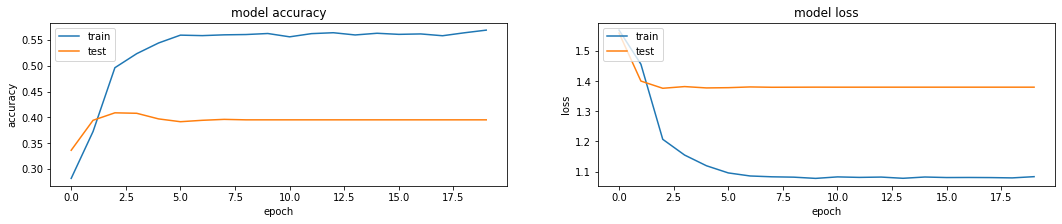

In [276]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#best_model_saver = ModelCheckpoint(filepath='./best_weights.hdf5', monitor="val_acc", mode='max', verbose=1,
#                                   save_best_only=True, save_weights_only=False)

best_model_saver = ModelCheckpoint(filepath='./best_weights.hdf5', monitor='val_loss',
                                   save_best_only=True, save_weights_only=False, mode='min', period=1)
#early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, mode='min',
#                              baseline=None, restore_best_weights=False)


### Training set
# From labels to one-hot vectors
int_train_labels = train_labels.astype('int')
y_train = np.zeros((int_train_labels.shape[0], n_classes))
for index, value in enumerate(int_train_labels):
    y_train[index,value] = 1
y_train = y_train.astype(int)
    
### Dev set
# From labels to one-hot vectors
int_dev_labels = dev_labels.astype('int')
y_dev = np.zeros((int_dev_labels.shape[0], n_classes))
for index, value in enumerate(int_dev_labels):
    y_dev[index,value] = 1
y_dev = y_dev.astype(int)

bs = 64
n_epochs = 20

history = model.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_dev, y_dev),
                    callbacks=[best_model_saver, lr_scheduler])#, early_stopper])

model = load_model('best_weights.hdf5')
predictions_one_hot = model.predict(x_dev)
predictions = np.zeros(predictions_one_hot.shape, dtype=int)
for idx in range(len(predictions_one_hot)):
    predictions[idx][np.argmax(predictions_one_hot[idx])] = 1

print('Validation accuracy of our best model : ', accuracy_score(y_dev, predictions))


### Let's plot the training curves
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Improvements : 
#   - Grid Search of parameters
#   - Attention mechanism ? (Transformers)
#   - Better Embedding

In [ ]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.
model = load_model('weights.best.hdf5')
predictions_one_hot = model.predict(x_test)
predictions = [np.argmax(pred) for pred in predictions_one_hot]

def write_submission(path_output, predictions):
    #function that writes the submission
    lines = '\n'.join([str(p) for p in predictions])
    with open(path_output,'w') as f:
        f.writelines(lines)

    
write_submission(os.path.join('.',r'logreg_lstm_y_test_sst.txt'), predictions)

## 4.3 - innovate !

In [334]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

from tensorflow.keras.layers import Layer, Dense, Attention, LayerNormalization, Concatenate, Add, \
                                    Dropout, Conv1D, MaxPool1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

K.clear_session()

class AttentionLayer(Layer):
    def __init__(self, fc_dim, **kwargs):
        super().__init__(**kwargs)
        self.fc_dim = fc_dim
    
    def build(self, input_shape):
        assert isinstance(input_shape, list)
        assert len(input_shape) == 3

        self.query_fc = Dense(self.fc_dim, activation="linear")
        self.value_fc = Dense(self.fc_dim, activation="linear")
        self.key_fc = Dense(self.fc_dim, activation="linear")

        self.att = Attention(use_scale=True)
        super().build(input_shape)
    
    def call(self, inputs):
        assert isinstance(inputs, list)
        query = inputs[0]
        value = inputs[1]
        if len(inputs) > 2 and inputs[2] is not None:
            key = inputs[2]
        else:
            key = value

        query = self.query_fc(query)
        value = self.value_fc(value)
        key = self.key_fc(key)

        return self.att([query, value, key])


class MultiHeadAttention(Layer):
    def __init__(self, n_heads, att_fc_dim, out_fc_dim, **kwargs):
        super().__init__(**kwargs)
        self.n_heads = n_heads
        self.att_fc_dim = att_fc_dim
        self.out_fc_dim = out_fc_dim
    
    def build(self, input_shape):
        assert isinstance(input_shape, list)
        query_shape = input_shape[0]
        # Attention heads
        for head in range(self.n_heads):
            setattr(self, "att_head_{}".format(head), 
                    AttentionLayer(fc_dim=self.att_fc_dim))
        
        self.out_fc = Dense(self.out_fc_dim, activation="linear")
        self.layer_norm1 = LayerNormalization()
        self.concat = Concatenate(axis=-1)        
        super().build(input_shape)

    def call(self, inputs):
        assert isinstance(inputs, list)
        query = inputs[0]
        value = inputs[1]
        if len(inputs) > 2 and inputs[2] is not None:
            key = inputs[2]
        else:
            key = value
        
        heads = []
        for num_head in range(self.n_heads):
            attention_head = getattr(self, "att_head_{}".format(num_head))
            heads.append(attention_head([query, value, key]))
        h = self.concat(heads)
        return self.out_fc(h)


### Architecture params
# Embeddings
max_len = 49
learned_embedding_dim = 300
embedding_dim = 300
vocab_size = 50000

# Prepare data
t = Tokenizer()
t.fit_on_texts(train_sentences)
vocab_size = len(t.word_index) + 1

X_train = pad_sequences(t.texts_to_sequences(train_sentences), maxlen=max_len, padding='post')
X_test = pad_sequences(t.texts_to_sequences(test_sentences), maxlen=max_len, padding='post')
X_dev = pad_sequences(t.texts_to_sequences(dev_sentences), maxlen=max_len, padding='post')
# if needed you can download the weights on the following website : https://nlp.stanford.edu/projects/glove/
embeddings_path = "./data/glove.42B.{}d.txt".format(embedding_dim)
embeddings_index = dict()
with open(embeddings_path, 'rt', encoding="utf-8") as f:
    for i, line in enumerate(f):
        word, vec = line.split(' ', 1)
        if word in t.word_index:
            embeddings_index[word] = np.fromstring(vec, sep=' ')
print('Loaded %s pretrained word vectors' % (len(embeddings_index)))

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Attention
att_fc_dim = 256
out_fc_dim = 256
heads = 8

# Convolutions
n_filters = 64
kernel_size = 4
pool_size = 3

# LSTM
lstm_dim = 256

# MLP & classifier
n_classes  = 5
dense_width = 512

### Forward pass
sentence = Input(shape=(max_len,))

### Embeddings
glove = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                  input_length=max_len, trainable=False)(sentence)
learned = Embedding(vocab_size, learned_embedding_dim, input_length=max_len)(sentence)
x = Concatenate(axis=-1)([glove, learned])

### Transformer Encoder 1
x_ = MultiHeadAttention(n_heads=heads, att_fc_dim=att_fc_dim, 
                       out_fc_dim=out_fc_dim)([x, x])
x = Dense(out_fc_dim, activation="relu")(x)
x = Add()([x, x_])
x = LayerNormalization()(x)

x_ = Dense(out_fc_dim, activation="relu")(x_)
x = Add()([x, x_])
x = LayerNormalization()(x)

### 1D Convolutions
x = Dropout(0.25)(x)
x = Conv1D(filters=n_filters, 
           kernel_size=kernel_size,
           activation='relu',
           padding='valid',
           strides=1)(x)
x = MaxPool1D(pool_size)(x)
x = Dropout(0.25)(x)
x = Conv1D(filters=n_filters, 
           kernel_size=kernel_size,
           activation='relu',
           padding='valid',
           strides=1)(x)
x = MaxPool1D(pool_size)(x)

### Pooling
x = GlobalAveragePooling1D()(x)

### Classifier
x = BatchNormalization()(x)
x = Dense(dense_width, activation="relu")(x)
x = Dropout(0.25)(x)

x = BatchNormalization()(x)
x = Dense(dense_width, activation="relu")(x)
x = Dropout(0.25)(x)

out = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=sentence, outputs=out)
print(model.summary())

Loaded 15175 pretrained word vectors
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 49)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 49, 300)      4601400     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 49, 300)      4601400     input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 49, 600)      0           embedding[0][0]                  
                                                         

In [336]:
# 4 - Define your loss/optimizer/metrics

### After a few trainings we see that the model needs a high learning rate to overcome some local maxima at first
# but then it doesn't fit properly. Thus we implement a learning rate scheduler to decrease the learning rate
# value after a few epochs.
from tensorflow.keras.callbacks import LearningRateScheduler
def schedule(epoch_idx, current_lr, step=6, decay=0.5):
    lr = current_lr
    if epoch_idx%step==(step-1):
        lr *= decay
    return lr

lr_scheduler = LearningRateScheduler(schedule)

loss_classif     =  'categorical_crossentropy'
# find the right loss for multi-class classification
optimizer        =  tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
# find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

In [ ]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#best_model_saver = ModelCheckpoint(filepath='./best_weights.hdf5', monitor="val_acc", mode='max', verbose=1,
#                                   save_best_only=True, save_weights_only=False)

best_model_saver = ModelCheckpoint(filepath='./transfo_best_weights.hdf5', monitor='val_loss',
                                   save_best_only=True, save_weights_only=True, mode='min', period=1)
#early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, mode='min',
#                              baseline=None, restore_best_weights=False)


### Training set
# From labels to one-hot vectors
int_train_labels = train_labels.astype('int')
y_train = np.zeros((int_train_labels.shape[0], n_classes))
for index, value in enumerate(int_train_labels):
    y_train[index,value] = 1
y_train = y_train.astype(int)
    
### Dev set
# From labels to one-hot vectors
int_dev_labels = dev_labels.astype('int')
y_dev = np.zeros((int_dev_labels.shape[0], n_classes))
for index, value in enumerate(int_dev_labels):
    y_dev[index,value] = 1
y_dev = y_dev.astype(int)

bs = 64
n_epochs = 20

history = model.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_dev, y_dev),
                    callbacks=[lr_scheduler,best_model_saver])#, early_stopper])

model.load_weights('transfo_best_weights.h5')
predictions_one_hot = model.predict(x_dev)
predictions = np.zeros(predictions_one_hot.shape, dtype=int)
for idx in range(len(predictions_one_hot)):
    predictions[idx][np.argmax(predictions_one_hot[idx])] = 1

print('Validation accuracy of our best model : ', accuracy_score(y_dev, predictions))


### Let's plot the training curves
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Improvements : 
#   - Grid Search of parameters
#   - Better Embedding

Train on 8544 samples, validate on 1101 samples
Epoch 1/20
1664/8544 [====>.........................] - ETA: 4:58 - loss: 3.2000 - accuracy: 0.2163